Jonathon Nguyen

ID: 801093003

Homework 3

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torchvision import datasets
import torch.optim as optim

import time
import datetime
import numpy as np
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt

<b>Problem 1a</b>  
Build a Convolutional Neural Network, like what we built in lectures (without skip connections), to classify the images across all 10 classes in CIFAR 10. 

You need to adjust the fully connected layer at the end properly with respect to the number of output classes. Train your network for 300 epochs. 

Report your training time, training loss, and evaluation accuracy after 300 epochs. Analyze your results in your report and compare them against a fully connected network (homework 2) on training time, achieved accuracy, and model size. Make sure to submit your code by providing the GitHub URL of your course repository for this course.

In [2]:
class CNN(nn.Module):
    def __init__(self, n_channels1 = 32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, self.n_channels1, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(n_channels1, (self.n_channels1 // 2), kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(8 * 8 * (self.n_channels1 // 2), 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = f.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = f.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * (self.n_channels1 // 2))
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
        

In [7]:
def training_loop(epochs, optimizer, model, loss_fn, train_loader, val_loader):
    training_losses = []
    val_losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        # Temp vars for use in finding the accuracy.
        correct_labels = 0
        count = 0
        loss_val_value = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                # Move the data to correct device
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                
                # Pass imgs through the model and find the loss.
                output = model(imgs)
                loss_val = loss_fn(output, labels)
                loss_val_value += float(loss_val)
                
                # Find the accurcey of the model.
                _, predicted = torch.max(output, dim=1)
                count += labels.shape[0]
                correct_labels += int((predicted == labels).sum())
            
            # Store the loss and accuracy.
            loss_val_value /= len(val_loader)
            val_losses.append(loss_val_value)
            accuracies.append(correct_labels/count)
        
        loss_train_value = 0
        for imgs, labels in train_loader:
            # Move the data to correct device
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            # Pass imgs through the model and find the loss.
            output = model(imgs)
            loss_train = loss_fn(output, labels)
            loss_train_value += float(loss_train)
            
            # Adject the params
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
        # Store the loss
        loss_train_value /= len(train_loader)
        training_losses.append(loss_train_value)
        
        # Print out the loss every 10 epoch
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch: {epoch}, Training Loss: {loss_train_value}", end="")
            print(f", Validation Loss: {loss_val_value}, Accuracy: {(correct_labels/count)*100}%")
        
    return training_losses, val_losses, accuracies

In [8]:
from torchvision import transforms

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
])

In [9]:
# Download the cifar10 dataset.
data = '.\cifar10'
cirfar10_train = datasets.CIFAR10(data, train=True, download=True, transform=transforms)
cirfar10_val = datasets.CIFAR10(data, train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
print(f"Training on {device}")

Training on cuda


In [7]:
NUM_EPOCHS = 10
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024

model = CNN().to(device=device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Load the data into a dataloaders.
train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)

val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [8]:
# Using time to time the training.
start_time = time.time()
training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
end_time = time.time()

# Close the threads
train_loader._iterator._shutdown_workers()
val_loader._iterator._shutdown_workers()

# Report the final stats about the training.
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: 2.2872167947340984, Validation Loss: 2.3182610273361206, Accuracy: 11.93%
Epoch: 10, Training Loss: 1.9267909526824951, Validation Loss: 1.9285465359687806, Accuracy: 31.96%
 
Final Loss: 1.9267909526824951, Final Accuracy: 31.96%
Training Time: 41.57 seconds


Text(0.5, 1.0, 'Losses')

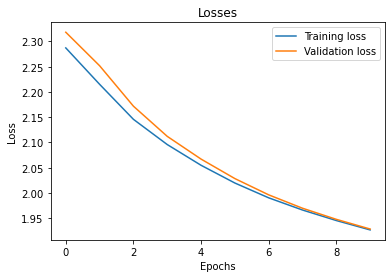

In [9]:
# Plotting the Losses

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Plot the model and the actual values.
plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Losses")

Text(0.5, 1.0, 'Accuracy')

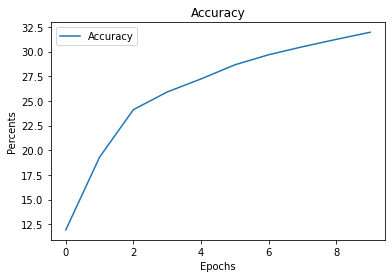

In [10]:
# Plotting the accuracy of the model.

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Percents")

for i, x in enumerate(accuracies):
    accuracies[i] = x * 100
    

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Accuracy")

<b>Problem 1b</b>  
Extend your CNN by adding one more additional convolution layer followed by an activation function and pooling function. 

You also need to adjust your fully connected layer properly with respect to intermediate feature dimensions. 

Train your network for 300 epochs. Report your training time, loss, and evaluation accuracy after 300 epochs. Analyze your results in your report and compare your model size and accuracy over the baseline implementation in Problem1a. Do you see any over-fitting? Make sure to submit your code by providing the GitHub URL of your course repository for this course.

In [11]:
class CNN2(nn.Module):
    def __init__(self, n_channels1 = 32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, self.n_channels1, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(n_channels1, (self.n_channels1 // 2), kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d((self.n_channels1 // 2), (self.n_channels1 // 4), kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(8 * 8 * (self.n_channels1 // 4), 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = f.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = f.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = f.max_pool2d(torch.tanh(self.conv3(out)), 2)
        out = out.view(-1, 8 * 8 * (self.n_channels1 // 4))
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [12]:
NUM_EPOCHS = 10
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024

model = CNN2().to(device=device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Load the data into a dataloaders.
train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)

val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [13]:
# Using time to time the training.
start_time = time.time()
training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
end_time = time.time()

# Close the threads
train_loader._iterator._shutdown_workers()
val_loader._iterator._shutdown_workers()

# Report the final stats about the training.
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

ValueError: Expected input batch_size (256) to match target batch_size (1024).